In [1]:
import numpy as np
from clothing_classifier import get_clothing_vector_model, get_img_vectors
from clothing_classifier import get_product_to_features, get_bottom_feature_indexes
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
from collections import defaultdict
import db.db as db
from sklearn.neighbors import KDTree, NearestNeighbors
import cv2
import urllib.request
import matplotlib.pyplot as plt

from itertools import permutations, combinations

%matplotlib inline

Using TensorFlow backend.


In [2]:
classifier_vector_model = get_clothing_vector_model()

Loaded model from disk


In [3]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'

jacket_feat = get_img_vectors(classifier_vector_model, jackets_img_path)
jacket_feat2 = get_img_vectors(classifier_vector_model, jackets_img_path2)
jeans_feat = get_img_vectors(classifier_vector_model, jeans_img_path)
dress_feat = get_img_vectors(classifier_vector_model, dress_img_path)

dress_feat.shape

(1024,)

In [4]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity([jacket_feat], [jacket_feat2]))
print('jeans and dress: ', cosine_similarity([jeans_feat], [dress_feat]))

2 jackets:  [[ 0.97938681]]
jeans and dress:  [[ 0.97675431]]


In [5]:
# compare euclidean distances
print('2 jackets: ', euclidean_distances([jacket_feat], [jacket_feat2]))
print('jeans and dress: ', euclidean_distances([jeans_feat], [dress_feat]))

2 jackets:  [[ 9.2059164]]
jeans and dress:  [[ 16.56675911]]


In [6]:
jacket_feat.shape # (1, 1024)

(1024,)

## Outfit Recommendations

In [22]:
FEATURE_COUNT=850
BOTTOM_FEATURE_INDEXES = get_bottom_feature_indexes(number_features_to_keep=FEATURE_COUNT)

def get_product_collections():
    collection_products = db.get_collection_products()
    product_to_collections = defaultdict(set)
    collections_to_products = defaultdict(list)
    product_info = {}
    for cp in collection_products:
        collection_id = str(cp[0])
        product_id = str(cp[1])
        product_name = cp[4]
        product_category = cp[2]
        image_url = cp[5]
        p = {'product_id': product_id,
             'product_name': product_name,
             'category': product_category,
             'image_url': image_url}
        product_to_collections[product_id].add(collection_id)
        collections_to_products[collection_id].append(p)
        product_info[product_id] = p
    return product_to_collections, collections_to_products, product_info


def get_closest_products(input_features, model, index_to_prod_mapping, count=15):
    """Only allow one product at a time"""
    product_distances, product_indexes = model.kneighbors(input_features, count, return_distance=True)
    closest_product_ids = [index_to_prod_mapping[index] for index in product_indexes[0]]
    return closest_product_ids, product_distances[0]


def get_product_category_to_type():
    return {'jeans': 'bottom',
            'shorts': 'bottom',
            'womens-pants': 'bottom',
            'skirts': 'bottom',
            'dresses': 'dress',
            'womens-tops': 'top',
            'sweaters': 'top',
            'sweatshirts': 'top',
            'jackets': 'coat',
            'womens-outerwear': 'coat',
            'handbags': 'accessories',
            'hats': 'accessories',
            'jewelry': 'accessories',
            'sunglasses': 'accessories',
            'womens-shoes': 'accessories'}


def is_valid_combo(types):
    is_invalid = (types.count('top') >= 2) or \
                 (types.count('bottom') >= 2) or \
                 (types.count('coat') >= 2) or \
                 (types.count('shoes') >= 2) or \
                 (types.count('dress') >= 2) or \
                 (types.count('accessories') > 2) or \
                 (types.count('dress') >= 1 and
                  types.count('bottom') >= 1) or \
                 (types.count('dress') >= 1 and
                  types.count('top') >= 1) or \
                 (types.count('accessories') == 1 and
                  len(types) == 2 and
                  types.count('top') == 1) or \
                 (types.count('accessories') >= 1 and
                  len(types) == 2 and
                  types.count('bottom') >= 1)

    return not is_invalid
        

def get_wardrobe_closest_collections(wardrobe_items, nn_model, 
                                     index_to_prod_mapping, prod_to_collection_mapping):
    """For every item in an wardrobe, get closest Shopstyle products
    used in curated collections and then corresponding collections"""
    wardrobe_closest = {}
    item_to_closest_prod_ids = defaultdict(list)
    for item in wardrobe_items:
        item_id = item['item_id']
        input_features = np.array(item['image_vector'])
        input_features_reduced = np.array([np.delete(input_features, BOTTOM_FEATURE_INDEXES)])
        closest_prods, prod_dists = get_closest_products(input_features_reduced, nn_model, 
                                                         index_to_prod_mapping, count=500)
        collection_ids_for_item = {}
        item_to_closest_prod_ids[str(item_id)] = closest_prods
        for prod_id, dist in zip(closest_prods, prod_dists):
            if dist < 6:
                collection_ids = prod_to_collection_mapping.get(prod_id, [])
                for cid in collection_ids:
                    collection_ids_for_item[cid] = dist
        wardrobe_closest[item_id] = collection_ids_for_item
    return wardrobe_closest, item_to_closest_prod_ids


def get_wardrobe_combinations(wardrobe_items):
    """Get combinations of items in wardrobe"""
    category_to_types = get_product_category_to_type()
    combos2 = list(combinations(wardrobe_items, 2))
    combos3 = list(combinations(wardrobe_items, 3))
    combos4 = list(combinations(wardrobe_items, 4))
    all_combos = combos2 + combos3 + combos4
    valid_combos = []
    for combo in all_combos:
        combo_types = [category_to_types[p['category']] for p in combo]
        if is_valid_combo(combo_types):
            valid_combos.append(combo)
    return valid_combos                

def display_images(image_paths):
    image_count = len(image_paths)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    if image_count == 1:
        image_file = image_paths[0]
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        plt.imshow(image, interpolation='nearest')
        plt.axis("off")
    else: 
        for i, image_file in enumerate(image_paths):
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
            ax[i].imshow(image, interpolation='nearest')
            ax[i].axis("off")
    plt.show()

def display_url_images(image_urls):
    image_count = len(image_urls)
    
    if image_count == 1:
        image_url = image_urls[0]
        req = urllib.request.urlopen(image_url)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr,-1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
    else: 
        fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
        for i, image_url in enumerate(image_urls):
            req = urllib.request.urlopen(image_url)
            arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
            img = cv2.imdecode(arr,-1)
            # Correct BGR to RGB channel
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i].imshow(img)
            ax[i].axis("off")
    plt.show()

    
def display_product_images(product_ids):
    image_files = ['images/images_collection_products/' + product_id + '.jpg' for product_id in product_ids]
    display_images(image_files)

    
def make_nn_model():
    """Return Nearest Neighbors model fitted on products in curated collections"""
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    prod_features = np.array(prod_features)
    print('Making Nearest Neighbors ...')
    nn_model = NearestNeighbors(n_neighbors=500, metric='l2', algorithm='auto')
    nn_model.fit(prod_features)
    return nn_model, index_to_prod, prod_features


def get_wardrobe_combo_collections(valid_combos, items_to_collections):
    """Return collections that match a wardrobe combination most closely"""    
    combo_to_closest_collections = {}
    for combo in valid_combos:
        combo_id = tuple([(str(item['item_id']), item['image_url']) for item in combo])
        collection_matches = None
        collection_match_to_distance = {}
        for item in combo:
            item_id = item['item_id']
            category = item['category']
            collections_dists_for_item = items_to_collections[item_id]
            collections_for_item = set(collections_dists_for_item.keys())
            if collection_matches is None:
                collection_matches = collections_for_item
            else:
                collection_matches = set.intersection(collection_matches, collections_for_item)
                
            # Find closest collections for combination
            for collection_id in collection_matches:
                coll_dist = collection_match_to_distance.get(collection_id, 0) + collections_dists_for_item[collection_id]
                collection_match_to_distance[collection_id] = coll_dist
        # If there are matching collections
        if len(collection_matches) > 0:      
            avg_collection_distances = []
            for coll_id in collection_matches:
                average_distance = collection_match_to_distance[coll_id] / float(len(combo_id))
                # Maximum average distance
                if average_distance < 5.2:
                    avg_collection_distances.append((coll_id, average_distance))
            avg_collection_distances = sorted(avg_collection_distances, key=lambda tup: tup[1])
            # Map every combination to matching collections and distance
            combo_to_closest_collections[combo_id] = avg_collection_distances
    return combo_to_closest_collections

def suggest_additional_products(items_to_collections, item_to_closest_prod_ids, excluded_item_ids):
    """Suggest more Shopstyle products to buy to complete the look"""
    item_to_missing_prods = {}
    for item_id, collections_dists_for_item in items_to_collections.items():
        item_id = str(item_id)
        if item_id not in excluded_item_ids:
            # Get collection with smallest distance
            sorted_collections = sorted(collections_dists_for_item.items(), key=lambda tup: tup[1])
            if len(sorted_collections) > 0:
                closest_collection_id = sorted_collections[0][0]
                closest_product_ids = set(item_to_closest_prod_ids[item_id])
                collection_products = cols_to_prod[closest_collection_id]  
                collection_products_ids = [p['product_id'] for p in collection_products]
                missing_product_ids = set(collection_products_ids) - closest_product_ids
                missing_products = [product_data[pid] for pid in missing_product_ids]
                item_to_missing_prods[item_id] = (closest_collection_id, missing_products)
    return item_to_missing_prods  


def get_sorted_combos(valid_combos, items_to_collections):
    closest_matches = get_wardrobe_combo_collections(valid_combos, items_to_collections)
    combo_to_closest_coll = []
    matched_item_ids = set([])
    for combo_id, matching_collections  in closest_matches.items():
        if len(matching_collections) > 0:
            item_ids = [i[0] for i in combo_id]
            matched_item_ids = matched_item_ids | set(item_ids)
            sorted_matching_colls = sorted(matching_collections, key=lambda tup: tup[1])
            # Store closest collection for each combination
            combo_to_closest_coll.append([combo_id, sorted_matching_colls[0]])
    
    combo_to_closest_coll = sorted(combo_to_closest_coll, key=lambda tup: tup[1][1])
    return combo_to_closest_coll, matched_item_ids

In [8]:
prod_to_colls, cols_to_prod, product_data = get_product_collections()
PRODUCT_FEATS_FILE = 'data-outfits/products_features.tsv'
prods_to_feats = get_product_to_features(product_feats_file=PRODUCT_FEATS_FILE, number_features_to_keep=FEATURE_COUNT)
neighbors_model, index_to_prod, prod_features = make_nn_model()

Making Nearest Neighbors ...


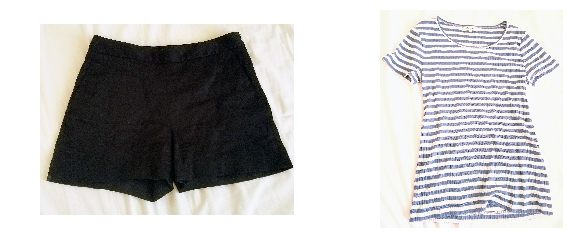

Distance:  4.26353756462


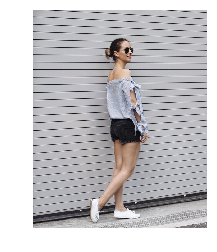

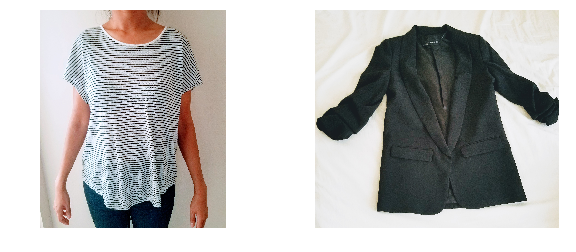

Distance:  4.68313157761


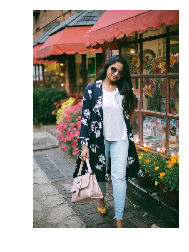

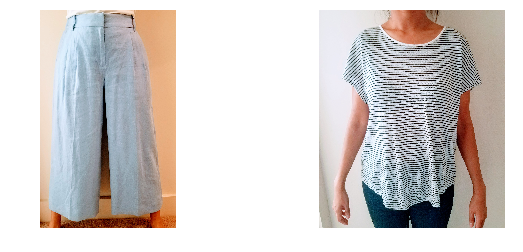

Distance:  4.72022545013


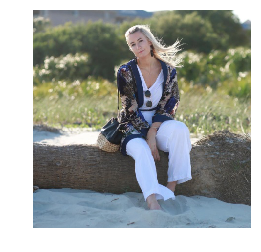

KeyboardInterrupt: 

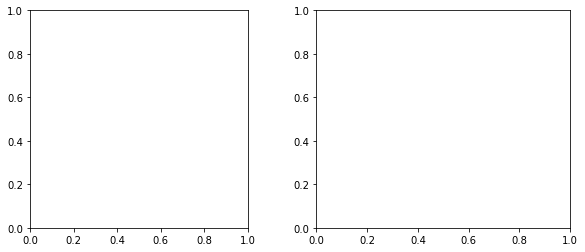

In [20]:
# Global Variables
conn = db.make_db_conn()
user_id = '5221de0a-cd0c-45a3-ac66-d1a6339ab446'
wardrobe_items = db.get_wardrobe_items(conn, user_id)
    
wardrobe_item_info = {}
for item in wardrobe_items:
    item_id = str(item[0])
    wardrobe_item_info[item_id] = {
        'image_url': item[1],
        'category': item[-1]
    }
        
# Items to closest collections and product ids
items_to_colls, item_to_prod_ids = get_wardrobe_closest_collections(
    wardrobe_items, neighbors_model, index_to_prod, prod_to_colls)
    
valid_combos = get_wardrobe_combinations(wardrobe_items)
    
matching_collections, matched_wardrobe_item_ids = get_sorted_combos(valid_combos, items_to_colls)
for combo_id, closest_collection in matching_collections:
    display_url_images([c[1] for c in combo_id])
    closest_collection_id = closest_collection[0]
    print('Distance: ', closest_collection[1])
    collection_path = 'images/images_collections/' + closest_collection_id + '.jpg'
    display_images([collection_path])



### Shopping Recommendations

-------- Item  805b9a15-c8a3-43ab-980f-5deab26bc05e


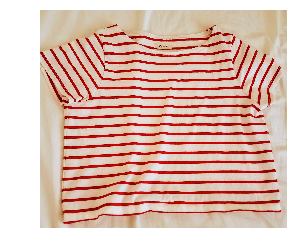

Closest collection:  42922656


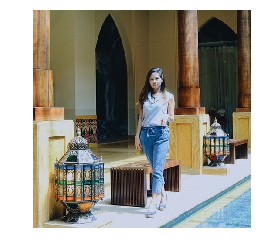

Suggested products: 


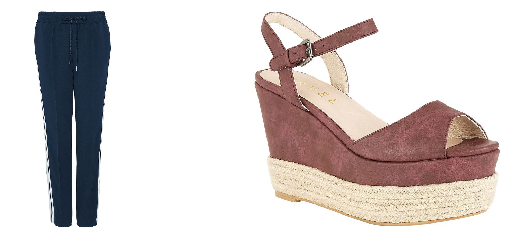

-------- Item  6a9f0723-a2dc-4a09-b790-9cf842e35f71


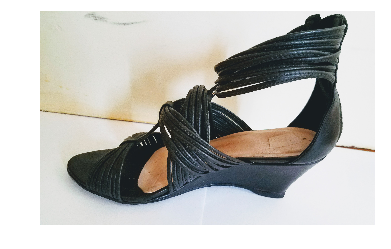

Closest collection:  42915592


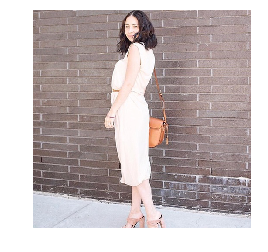

Suggested products: 


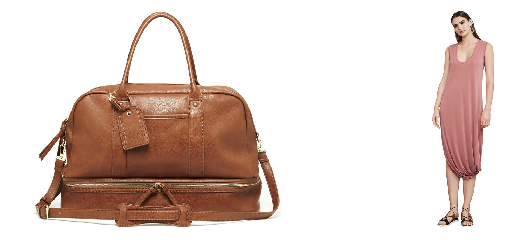

-------- Item  0c1760fe-5db6-416f-ad1c-1f83d9412080


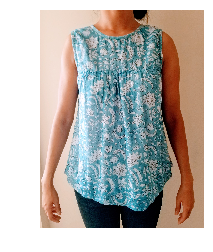

Closest collection:  42910767


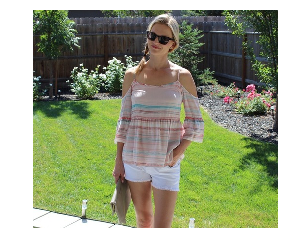

Suggested products: 


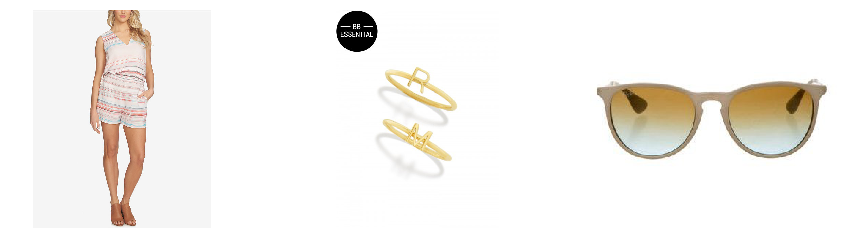

-------- Item  df80bb99-1326-4d3e-b1e4-0b30f9e35304


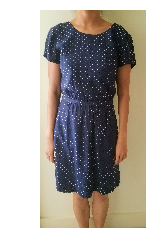

Closest collection:  42911651


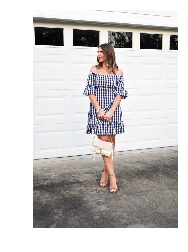

Suggested products: 


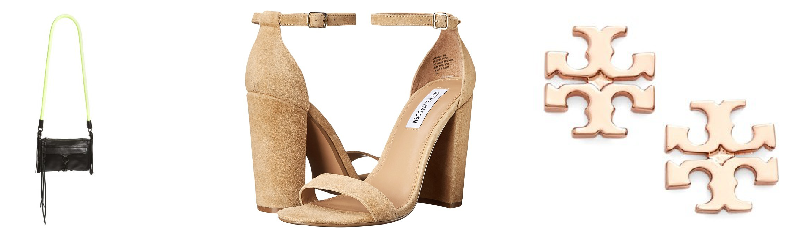

-------- Item  6038d696-8f4f-46c6-9808-65c360374934


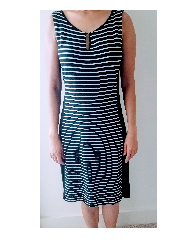

Closest collection:  42916425


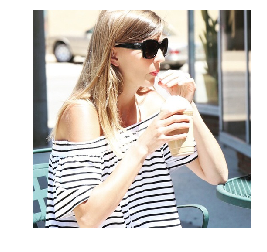

-------- Item  1e7d798e-b637-4e73-8043-a5eb24f5e23f


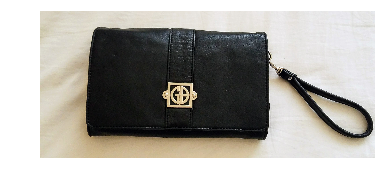

Closest collection:  42872981


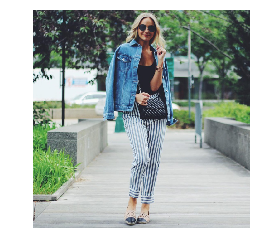

Suggested products: 


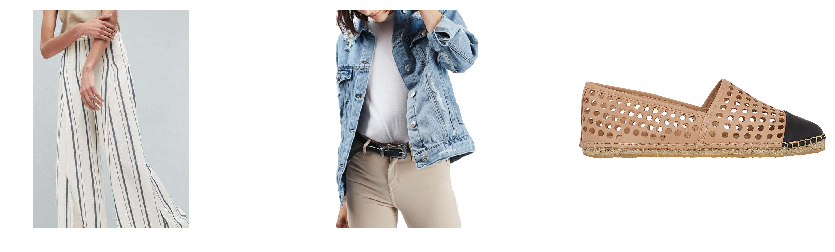

-------- Item  e66fc553-c353-4ad4-9be0-c4f9134a1a30


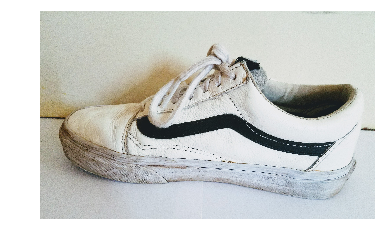

Closest collection:  42813913


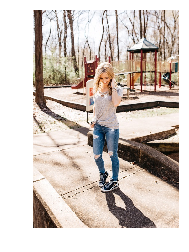

Suggested products: 


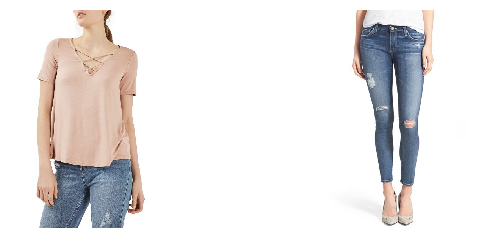

-------- Item  d319af84-12a9-4da0-a4d0-5ccbc473e523


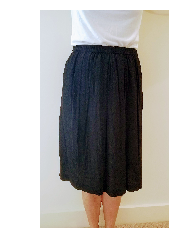

Closest collection:  42911010


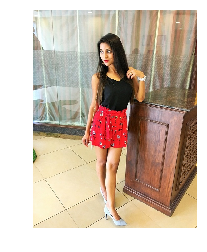

Suggested products: 


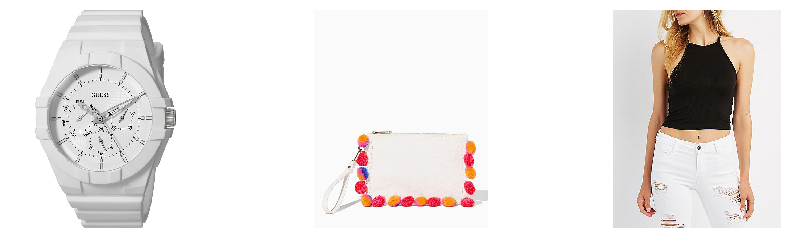

In [24]:
item_to_missing_prods = suggest_additional_products(items_to_colls, item_to_prod_ids, matched_wardrobe_item_ids)

for item_id, closest_coll in item_to_missing_prods.items():
    print('-------- Item ', item_id)
    wardrobe_item = wardrobe_item_info[item_id]
    item_image_url = wardrobe_item['image_url']
    item_category = wardrobe_item['category']
    display_url_images([item_image_url])
    
    closest_collection_id = closest_coll[0]
    print('Closest collection: ', closest_collection_id)
    collection_paths = ['images/images_collections/' + closest_collection_id + '.jpg']
    display_images(collection_paths)
    
    # Exclude any items from current category
    suggested_products = [] 
    suggested_product_categories = set()
    for p in closest_coll[1]:
        curr_category = p['category']
        # Suggest products in unique categories
        if (curr_category != item_category) and (curr_category not in suggested_product_categories):
            suggested_product_categories.add(curr_category)
            suggested_products.append(p)
            
    suggested_product_count = len(suggested_products)
    if suggested_product_count > 0:
        print('Suggested products: ')
        display_url_images([p['image_url'] for p in suggested_products[: (min(3, suggested_product_count))]])
    

### Testing

In [ ]:
white_shirt_id = '625552248'
pink_bag_id = '430848442'
display_product_images([white_shirt_id, pink_bag_id])

In [ ]:
white_shirt_vector = prods_to_feats[white_shirt_id]
closest_white_shirt_ids, closest_white_shirt_distances = get_closest_products(white_shirt_vector, neighbors_model, index_to_prod, count=1000)
display_product_images(closest_white_shirt_ids[:15])
closest_white_shirt_distances[:15]

In [ ]:
# furthest white shirts
furthest_white_shirt_ids = closest_white_shirt_ids[::-1]
furthest_white_shirt_distances = closest_white_shirt_distances[::-1]
display_product_images(furthest_white_shirt_ids[900:915])
furthest_white_shirt_distances[900:915]

In [ ]:
pink_bag_vector = prods_to_feats[pink_bag_id]
closest_pink_bag_ids, closest_pink_bag_dists= get_closest_products(pink_bag_vector, neighbors_model, index_to_prod)
display_product_images(closest_pink_bag_ids)
closest_pink_bag_dists

In [ ]:
conn = db.make_db_conn()

In [ ]:
nana_user_id = '5221de0a-cd0c-45a3-ac66-d1a6339ab446'
test_wardrobe_items = db.get_wardrobe_items(conn, nana_user_id)
test_wardrobe_item_to_feat = {}
for i in test_wardrobe_items:
    test_wardrobe_item_to_feat[str(i['item_id'])] = {'vector': i['image_vector'], 
                                                     'url': i['image_url'],
                                                     'category': i['category']}
    
for test_item_id in test_wardrobe_item_to_feat.keys():
    test_feat = test_wardrobe_item_to_feat[test_item_id]['vector']
    test_image_url = test_wardrobe_item_to_feat[test_item_id]['url']
    test_image_category = test_wardrobe_item_to_feat[test_item_id]['category']
    print(test_item_id, ' / ', test_image_category)
    display_url_images([test_image_url])
    test_feat_reduced = np.array([np.delete(test_feat, BOTTOM_FEATURE_INDEXES)])
    closest_test_ids, closest_test_dists= get_closest_products(test_feat_reduced, neighbors_model, index_to_prod)
    display_product_images(closest_test_ids)
    print(closest_test_dists)